(16236,)
(667, 620)


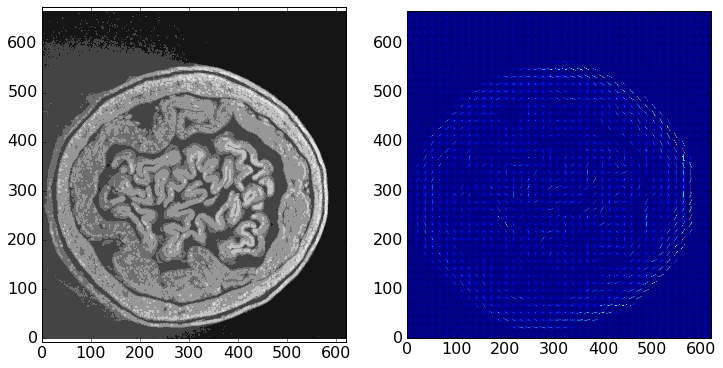

In [3]:
import numpy as np
import glob
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy import ndimage
from skimage.measure import moments
from skimage.feature import hog
import matplotlib
from scipy.interpolate import interp2d

# open first image to get the image dimensions
im1 = np.array(Image.open('sargentii_17/batch3_tomo_areaij_sample17.0503.tif'),dtype=np.double)

clustered_img1 = KMeans(2).fit_predict(im1.reshape([np.prod(np.shape(im1)),1]))            
clustered_img1[clustered_img1 == clustered_img1[0]] = 2e0
clustered_img1[clustered_img1 != clustered_img1[0]] = 3e0
clustered_img1 = clustered_img1 - 2e0
clustered_img1 = clustered_img1.reshape(np.shape(im1))
clustered_img1 = np.array(clustered_img1,dtype=np.double)

m1 = moments(clustered_img1)
cr1 = m1[0, 1] / m1[0, 0]
cc1 = m1[1, 0] / m1[0, 0]


feature_vector, hog_image = hog(im1,orientations=9,pixels_per_cell=(15,15),cells_per_block=(1,1),visualise=True,normalise=True)

print np.shape(feature_vector)
print np.shape(hog_image)


plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.axis('equal')
plt.ylim([0,np.shape(im1)[0]])
plt.xlim([0,np.shape(im1)[1]])
plt.contourf(im1,cmap='Greys_r')
#plt.scatter(cr1,cc1,color='r')

plt.subplot(1, 2, 2)
plt.ylim([0,np.shape(hog_image)[0]])
plt.xlim([0,np.shape(hog_image)[1]])
plt.imshow(hog_image)
plt.savefig('imgs/hog_image.png',dpi=150)

plt.show()


In [4]:
import numpy as np
from PIL import Image
import os
import pickle
from scipy.misc import imresize
import pylab as pl

# label a set of tiles: labels can be background, leaf, or shell
# save the training data

# number of tiles/class to find
# all tiles will be rotated by 90, 180, and 270 degrees to increase sample size and ensure rotation invariance
n = 400

# pixel size of the tiles
size = 50

# arrays to save stuff
tiles = np.empty(shape=[size,size,n])
labels = np.zeros(n)

i=0
ii=0
iii=0
count = 0
while count < n:
    # get random pixel from the image
    x = np.random.randint(np.shape(im1)[0]-size)
    y = np.random.randint(np.shape(im1)[1]-size)
    
    plt.title(str(i)+'-background, '+str(iii)+'-shell, '+str(ii)+'-leaf, '+str(count)+'-total')
    plt.contourf(im1.T,cmap='Greys_r')
    square = plt.Rectangle((x,y),size,size,color='r',fill=False)
    plt.gca().add_patch(square)
    plt.contourf(im1[x:x+size,y:y+size].T)
    coord = pl.ginput(1,timeout=0)
    pl.close()

    # click on the left if it's background
    if coord[0][0] < np.shape(im1)[0]/3:
        tiles[:,:,count] = im1[x:x+size,y:y+size]
        labels[count] = 0
        i = i + 1
        count = count + 1
    # click on the right if it is leaf:
    elif coord[0][0] > 2*np.shape(im1)[0]/3:
        tiles[:,:,count] = im1[x:x+size,y:y+size]
        labels[count] = 1  
        ii = ii + 1 
        count = count + 1
    # click to the middle if it is shell
    elif coord[0][0] > np.shape(im1)[0]/3 and coord[0][0] < 2*np.shape(im1)[0]/3:
        tiles[:,:,count] = im1[x:x+size,y:y+size]
        labels[count] = 2
        iii = iii + 1 
        count = count + 1

# rotate the tiles and pickle dump the arrays
new_tiles = np.append(tiles,np.rot90(tiles,k=1),axis=2)
new_labels = np.append(labels,labels)

new_tiles = np.append(new_tiles,np.rot90(tiles,k=2),axis=2)
new_labels = np.append(new_labels,labels)

new_tiles = np.append(new_tiles,np.rot90(tiles,k=3),axis=2)
new_labels = np.append(new_labels,labels)

# check whether training data files already exist. if it is, append the old values.
file_name = 'training_data_'+str(size)+'x'+str(size)+'.dat'
if os.path.isfile(file_name):

    f = open(file_name,'r')
    [old_tiles,old_labels] = pickle.load(f)
    f.close()

    # add the old labeled tiles
    new_tiles = np.append(old_tiles,new_tiles,axis=2)
    new_labels = np.append(old_labels,new_labels)

f = open(file_name,'w')
pickle.dump([new_tiles,new_labels],f)
f.close()    

print 'finished'

NameError: name 'stop' is not defined

In [5]:
#do PCA
import numpy as np
import pylab as plt
'''
Performs the Principal Coponent analysis of the Matrix X
Matrix must be n * m dimensions
where n is # features
m is # examples
'''

def PCA(X, varRetained = [0.95],filename = 'PCA_data.dat'):

    # Compute Covariance Matrix Sigma
    (n, m) = X.shape

    Sigma = 1.0 / float(m) * np.dot(X, np.transpose(X))
    # Compute eigenvectors and eigenvalues of Sigma
    U, s, V = np.linalg.svd(Sigma)

    # compute the value k: number of minumum features that 
    # retains the given variance
    s_tot = np.sum(s)
        
    var_i = np.array([np.sum(s[: i + 1]) / s_tot * 100.0 for i in range(n)])
    
    k = np.zeros(len(varRetained))
    for i in range(len(k)):
        k[i] = len(var_i[var_i < (varRetained[i] * 100e0)])

        print '%.2f %% variance retained in %d dimensions' % (var_i[k[i]], k[i])

        # compute the reduced dimensional features 
        U_reduced = U[:, : k[i]]
        Z = np.dot(np.transpose(U_reduced),X)

        # pickle dump the results
        f = open(filename+str(int(varRetained[i]*100e0))+'.dat','w')
        pickle.dump([Z, U_reduced, k[i]],f)
        f.close() 

    return 


var_ret = [0.80, 0.85, 0.90, 0.95, 0.99] 

# load the training data and divide it to training (60%), test (20%), and cross validation (20%) sets
f = open('training_data_'+str(size)+'x'+str(size)+'.dat','r')
[tiles,labels] = pickle.load(f)
f.close()

# standardize tiles
tiles_standard = np.zeros(np.shape(tiles))
for i in range(len(labels)):
    tiles_standard[:,:,i] = (tiles[:,:,i] - np.mean(im1) ) / np.std(im1)

# reshape tiles
reshape_tiles = np.reshape(tiles_standard,[size*size,len(labels)])

filename = 'PCA_data_'+str(size)+'x'+str(size)+'_var0'

# do PCA and save the results
PCA(reshape_tiles,varRetained = var_ret,filename = filename)

print 'finished'



/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:30: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:33: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


80.34 % variance retained in 17 dimensions
85.03 % variance retained in 26 dimensions
90.24 % variance retained in 42 dimensions
95.04 % variance retained in 81 dimensions
99.00 % variance retained in 286 dimensions
finished


In [5]:
# run the SVM
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
matplotlib.rcParams.update({'font.size': 16})
matplotlib.rcParams['figure.figsize'] = (9.0, 6.0)
from sklearn.svm import SVC
import pickle
from scipy.misc import imresize

# number of simulations 
n_sim = 100

var = 0.99

file_name = 'training_data_'+str(size)+'x'+str(size)+'.dat'
f = open(file_name,'r')
[X,Y] = pickle.load(f)
f.close()  


f = open('PCA_data_'+str(size)+'x'+str(size)+'_var0'+str(int(var*100e0))+'.dat','r')
[Z, U_reduced, k] = pickle.load(f)
f.close()


# range of C and gamma values
# the range used to be wider: -8e0,3e0 with num = 12
# experience showed that the best C is within this reduced range usually
C = 10e0**(np.linspace(0e0,4e0,5))
gamma = 10e0**(np.linspace(-4e0,0e0,5))

train_score = np.zeros([n_sim,len(C),len(gamma)])
test_score = np.zeros([n_sim,len(C),len(gamma)])
CV_score = np.zeros([n_sim,len(C),len(gamma)])

for i in range(n_sim):
    print '   ',i
    # shuffle and split data
    indx = np.arange(np.shape(Z.T)[0])
    np.random.shuffle(indx)
    # split 60-20-20%
    split1 = int(np.shape(Z.T)[0]*0.6)
    split2 = int(np.shape(Z.T)[0]*0.8)
    X_train = Z.T[indx[:split1]]
    Y_train = Y[indx[:split1]]
    X_test = Z.T[indx[split1:split2]]
    Y_test = Y[indx[split1:split2]]
    X_CV = Z.T[indx[split2:]]
    Y_CV = Y[indx[split2:]]


    # train SVM and loop through all C and gamma combinations
    for j in range(len(C)):
        for k in range(len(gamma)):
            #print '      C and gamma:',C[j],gamma[k]
            SVC_bud = SVC(kernel='rbf', C=C[j], gamma=gamma[k]).fit(X_train, Y_train)            
            train_score[i,j,k] = SVC_bud.score(X_train,Y_train)
            test_score[i,j,k] = SVC_bud.score(X_test,Y_test)
            CV_score[i,j,k] = SVC_bud.score(X_CV,Y_CV)


    # find the C and gamma parameters that give max score.
    # if there are multiple parameter configuration giving max score, the first one of these is used below 
    best_params = np.where(test_score[i,:,:] == np.max(test_score[i,:,:]))
    print '   best C value(s):',C[best_params[0]]
    print '   best gamma value(s):',gamma[best_params[1]]
    print '   max test score:',np.max(test_score[i,:,:])



avg_score = np.mean(test_score[:,:,:],axis=0)
avg_CV_score = np.mean(CV_score[:,:,:],axis=0)
std_CV_score = np.std(CV_score[:,:,:],axis=0)

best_params = np.where(avg_score == np.max(avg_score))
print 'best C value(s):',C[best_params[0]]
print 'best gamma value(s):',gamma[best_params[1]]
print 'max test score:',np.max(avg_score)

print 'CV score:',avg_CV_score[best_params],'+/-',std_CV_score[best_params]
# train the best SVM and save it
SVC_bud = SVC(kernel='rbf', C=C[best_params[0][0]], gamma=gamma[best_params[1][0]]).fit(Z.T, Y)            


# save the results
f = open('SVM_tile_scores_nsim'+str(n_sim)+'_'+str(size)+'x'+str(size)+'_var0'+str(int(var*100e0))+'.dat','w')
pickle.dump([test_score,train_score,CV_score,SVC_bud,C,gamma],f)
f.close()



    0
   best C value(s): [ 10.]
   best gamma value(s): [ 0.0001]
   max test score: 0.8625
    1
   best C value(s): [    10.    100.   1000.  10000.]
   best gamma value(s): [ 0.001  0.001  0.001  0.001]
   max test score: 0.8546875
    2
   best C value(s): [   100.   1000.  10000.]
   best gamma value(s): [ 0.001  0.001  0.001]
   max test score: 0.8453125
    3
   best C value(s): [    10.    100.   1000.  10000.]
   best gamma value(s): [ 0.001  0.001  0.001  0.001]
   max test score: 0.8515625
    4
   best C value(s): [   100.   1000.  10000.]
   best gamma value(s): [ 0.001  0.001  0.001]
   max test score: 0.871875
    5
   best C value(s): [    10.    100.   1000.  10000.]
   best gamma value(s): [ 0.001  0.001  0.001  0.001]
   max test score: 0.8453125
    6
   best C value(s): [   100.   1000.  10000.]
   best gamma value(s): [ 0.001  0.001  0.001]
   max test score: 0.8734375
    7
   best C value(s): [    10.    100.   1000.  10000.]
   best gamma value(s): [ 0.001  0.

In [6]:
# render the image
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
matplotlib.rcParams.update({'font.size': 16})
matplotlib.rcParams['figure.figsize'] = (9.0, 6.0)
from sklearn.svm import SVC
from skimage.util.shape import view_as_windows
import pickle

f = open('PCA_data_'+str(size)+'x'+str(size)+'_var0'+str(int(var*100e0))+'.dat','r')
[Z, U_reduced, k] = pickle.load(f)
f.close()

f = open('SVM_tile_scores_nsim100_'+str(size)+'x'+str(size)+'_var0'+str(int(var*100e0))+'.dat','r')
[test_score,train_score,CV_score,SVC_bud,C,gamma] = pickle.load(f)
f.close()

windows = view_as_windows(im1,(size,size))

PCA_features = np.zeros([np.shape(windows)[0],np.shape(windows)[1],np.shape(Z)[0]])

class_img = np.zeros([np.shape(windows)[0],np.shape(windows)[1]])

# collect the PCA features

mean_im = np.mean(im1)
std_im = np.std(im1)
for i in range(np.shape(windows)[0]):
    if i%100 == 0:
        print i
    for j in range(np.shape(windows)[1]):

        tile_standard = (windows[i,j] - mean_im)/std_im
        reshape_tile = tile_standard.reshape(size*size)
        PCA_features[i,j,:] = np.dot(reshape_tile,U_reduced)

# predict the classes:
for i in range(np.shape(windows)[0]):
    if i%100 == 0:
        print i
    class_img[i,:] = SVC_bud.predict(PCA_features[i,:,:])

plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.axis('equal')
plt.xlim([0,np.shape(im1)[0]])
plt.ylim([0,np.shape(im1)[1]])
plt.imshow(im1,cmap='Greys_r')
#plt.scatter(cr1,cc1,color='r')

plt.subplot(1, 2, 2)
plt.xlim([0,np.shape(hog_image)[0]])
plt.ylim([0,np.shape(hog_image)[1]])
plt.imshow(class_img)
plt.savefig('imgs/class_tiles_size'+str(size)+'.png',dpi=150)
plt.close()


0
100
200
300
400
500
600
0
100
200
300
400
500
600


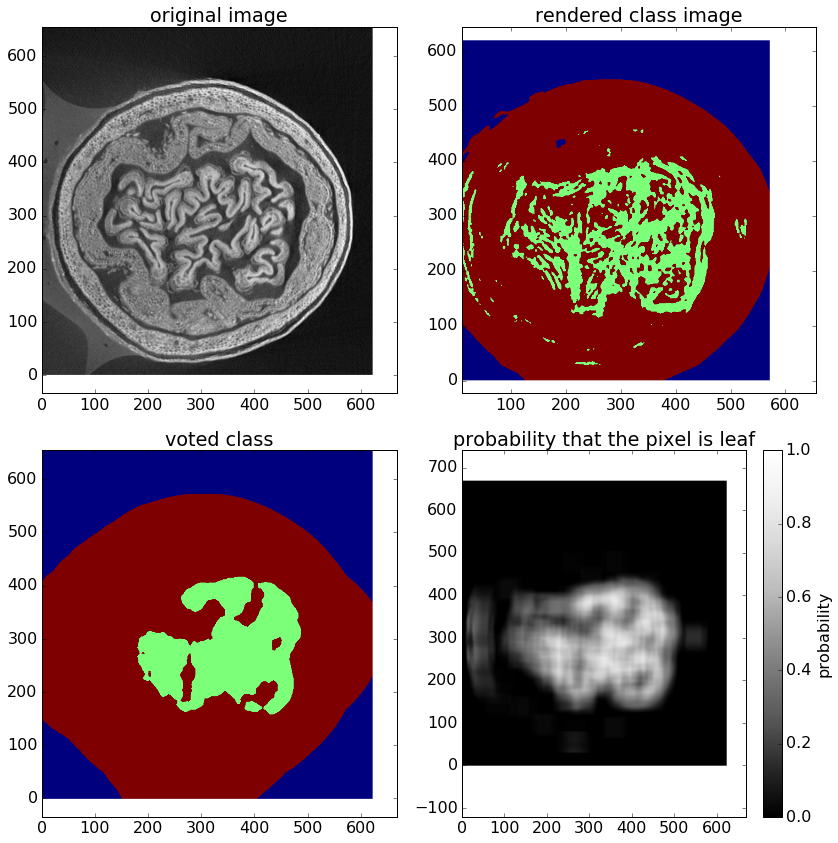

In [7]:
# do the voting

voted_classes = np.zeros(np.shape(im1))
leaf_prob = np.zeros(np.shape(im1))

for i in range(np.shape(im1)[0]):
    for j in range(np.shape(im1)[1]):
        x_range = np.arange(i-(size-1),i+1)
        y_range = np.arange(j-(size-1),j+1)
        
        x_indcs = x_range[np.where((x_range >=0)&(x_range<np.shape(class_img)[0]))[0]]
        y_indcs = y_range[np.where((y_range >=0)&(y_range<np.shape(class_img)[1]))[0]]
                
        votes = class_img[x_indcs[0]:x_indcs[-1]+1,y_indcs[0]:y_indcs[-1]+1].flatten()
                
        unique,counts = np.unique(votes,return_counts = True)

        voted_classes[i,j] = unique[counts.argmax()]
        
        leaf_prob[i,j] = 1e0*len(votes[votes == 1]) / len(votes)

plt.figure(figsize=(12,12))
plt.subplot(2, 2, 1)
plt.axis('equal')
plt.title('original image')
plt.xlim([0,np.shape(im1)[0]])
plt.ylim([0,np.shape(im1)[1]])
plt.imshow(im1,cmap='Greys_r')
#plt.scatter(cr1,cc1,color='r')

plt.subplot(2, 2, 2)
plt.axis('equal')
plt.title('rendered class image')
plt.xlim([0,np.shape(hog_image)[0]])
plt.ylim([0,np.shape(hog_image)[1]])
plt.imshow(class_img)

plt.subplot(2, 2, 3)
plt.axis('equal')
plt.title('voted class')
plt.xlim([0,np.shape(im1)[0]])
plt.ylim([0,np.shape(im1)[1]])
plt.imshow(voted_classes)

plt.subplot(2, 2, 4)
plt.axis('equal')
plt.title('probability that the pixel is leaf')
plt.xlim([0,np.shape(im1)[0]])
plt.ylim([0,np.shape(im1)[1]])
plt.imshow(leaf_prob,cmap='Greys_r',vmin=0,vmax=1)
           
           #levels = np.linspace(0,1,num=101,endpoint=True))
cb = plt.colorbar(ticks = np.linspace(0,1,num=6,endpoint=True))
cb.set_label('probability')
plt.tight_layout()
plt.savefig('imgs/class_voted_tiles_size'+str(size)+'.png',dpi=150)
plt.show()
plt.close()



